# Tabular Anomaly GAN from Scratch using Pytorch

The below code is a modifications of the [Pytorch DCGAN tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) together with the integration of anomaly detection.

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
import os
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('../datasets/income/adult.csv')

In [5]:
df_dropped = df.drop('income', axis=1)

In [6]:
categorical_columns = [col for col in df_dropped.columns if df_dropped[col].dtype == 'object']
numerical_columns = [col for col in df_dropped.columns if df_dropped[col].dtype in ['int64', 'float64']]

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(sparse_output=False), categorical_columns),
    ])

In [8]:
X = preprocessor.fit_transform(df_dropped)
y = df['income'].apply(lambda x: 1 if x == '>50K' else 0).values

In [9]:
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32)

In [10]:
dataset = TensorDataset(X_torch, y_torch)

In [11]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [12]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.net(x)

In [13]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

In [14]:
noise_dim = 100
generator = Generator(input_dim=noise_dim, output_dim=X.shape[1])
discriminator = Discriminator(input_dim=X.shape[1])

In [15]:
criterion = nn.BCELoss()
optimizer_generator = optim.Adam(generator.parameters(), lr=0.00040376804222956743)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=2.019033675863192e-05)

The basic training loop for the GAN should look as following

In [16]:
epochs = 25

# Lists to keep track of progress
record_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(epochs):
    for i, batch in enumerate(dataloader, 0):
        # Update Discriminator with Real Data
        discriminator.zero_grad()
        real_data, _ = batch
        real_labels = torch.ones(real_data.size(0), 1)
        output_real = discriminator(real_data)
        loss_real = criterion(output_real, real_labels)
        
        # Update Discriminator with Fake Data
        noise = torch.randn(real_data.size(0), noise_dim)
        fake_data = generator(noise)
        fake_labels = torch.zeros(real_data.size(0), 1)
        output_fake = discriminator(fake_data.detach())
        loss_fake = criterion(output_fake, fake_labels)
        
        # Combine Losses for discriminator and Update
        loss_disc = loss_real + loss_fake
        loss_disc.backward()
        optimizer_discriminator.step()
        
        # Update Generator
        generator.zero_grad()
        output = discriminator(fake_data)
        loss_gen = criterion(output, real_labels)
        loss_gen.backward()
        optimizer_generator.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' 
                  % (epoch, epochs, i, len(dataloader), loss_disc.item(), loss_gen.item(), output_real.mean().item(), output_fake.mean().item(), output.mean().item()))

        # Save Losses for plotting later
        G_losses.append(loss_gen.item())
        D_losses.append(loss_disc.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(noise).detach().cpu()
            record_list.append(fake)

        iters += 1

# Save models for each trial temporarily
model_dir = f'../experiments/vanilla_gan/model/vanillaGAN'
os.makedirs(model_dir, exist_ok=True)
torch.save(generator.state_dict(), os.path.join(model_dir, 'generator.pth'))
torch.save(discriminator.state_dict(), os.path.join(model_dir, 'discriminator.pth'))

[0/25][0/1018]	Loss_D: 1.3913	Loss_G: 0.7077	D(x): 0.4905	D(G(z)): 0.4928 / 0.4928
[0/25][50/1018]	Loss_D: 1.3893	Loss_G: 0.6945	D(x): 0.5002	D(G(z)): 0.5017 / 0.4993
[0/25][100/1018]	Loss_D: 1.3198	Loss_G: 0.7575	D(x): 0.5055	D(G(z)): 0.4714 / 0.4688
[0/25][150/1018]	Loss_D: 1.4028	Loss_G: 0.6735	D(x): 0.5046	D(G(z)): 0.5127 / 0.5099
[0/25][200/1018]	Loss_D: 1.3412	Loss_G: 0.7395	D(x): 0.5040	D(G(z)): 0.4811 / 0.4774
[0/25][250/1018]	Loss_D: 1.2660	Loss_G: 0.8323	D(x): 0.5024	D(G(z)): 0.4388 / 0.4351
[0/25][300/1018]	Loss_D: 1.3231	Loss_G: 0.7644	D(x): 0.5014	D(G(z)): 0.4689 / 0.4656
[0/25][350/1018]	Loss_D: 1.1843	Loss_G: 0.9513	D(x): 0.5014	D(G(z)): 0.3898 / 0.3862
[0/25][400/1018]	Loss_D: 1.2385	Loss_G: 0.8703	D(x): 0.5028	D(G(z)): 0.4234 / 0.4188
[0/25][450/1018]	Loss_D: 1.0793	Loss_G: 1.1404	D(x): 0.5042	D(G(z)): 0.3256 / 0.3202
[0/25][500/1018]	Loss_D: 1.2110	Loss_G: 0.9272	D(x): 0.4984	D(G(z)): 0.4016 / 0.3965
[0/25][550/1018]	Loss_D: 1.1870	Loss_G: 1.0104	D(x): 0.5086	D(G(z)):

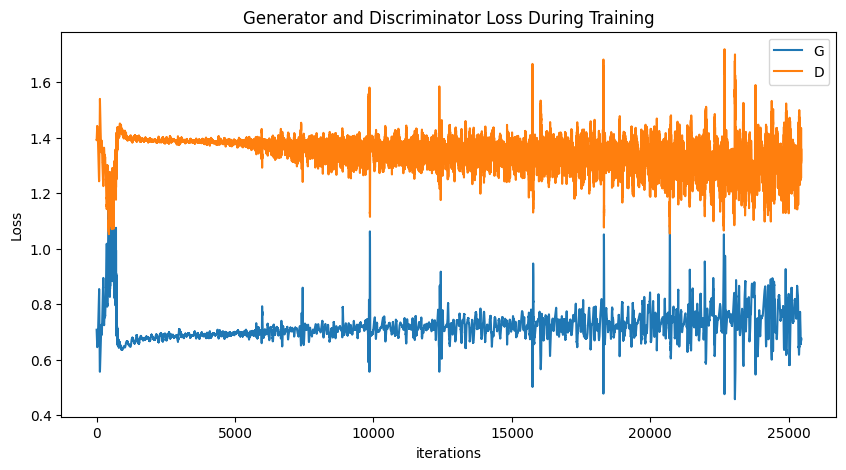

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Hyperparameter Finetuning

Initial experiments on 50 epochs with some initial parameters show a lot of the expected behaviours such as early fluctations in losses.

However, the discriminator loss seems to decrease, while the generator loss seems to increase most of the times (though, not necessarily in an oscillation manner, which would somewhat be expected). The discriminator loss reaches a point where it becomes really small, like the generator loss increases towards a loss of 5.

As a way to experiment with other parameters to see its performance, we'll utilize Optuma's Hyperparameter optimizer to potentially find better hyperparameters.

**Note**: Do not run when implementing basic

In [60]:
def optuna_optimize(trial, X, dataloader):
    # Define Hyperparameters to optimize
    lr_gen = trial.suggest_float('lr_gen', 1e-5, 1e-3)
    lr_disc = trial.suggest_float('lr_disc', 1e-5, 1e-3)

    # Initialize Models
    generator = Generator(input_dim=100, output_dim=X.shape[1])
    discriminator = Discriminator(input_dim=X.shape[1])
    
    # Optimizers
    criterion = nn.BCELoss()
    optimizer_gen = optim.Adam(generator.parameters(), lr=lr_gen)
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr_disc)

    epochs = 10

    for epoch in range(epochs):
        for i, (data, _) in enumerate(dataloader):
            # Number of data points
            n_data = data.size(0)

            # Train Discriminator
            real_data = data
            real_labels = torch.ones(n_data, 1)
            fake_labels = torch.zeros(n_data, 1)

            discriminator.zero_grad()
            output_real = discriminator(real_data)
            loss_real = criterion(output_real, real_labels)

            noise = torch.randn(n_data, 100)
            fake_data = generator(noise)
            output_fake = discriminator(fake_data.detach())
            loss_fake = criterion(output_fake, fake_labels)

            loss_d = loss_real + loss_fake
            loss_d.backward()
            optimizer_disc.step()

            generator.zero_grad()
            output = discriminator(fake_data)
            loss_g = criterion(output, real_labels)
            loss_g.backward()
            optimizer_gen.step()

    # Example metric to optimize could be the last generator loss
    metric_to_optimize = loss_g.item()

    # Save models for each trial temporarily
    trial_model_dir = f'../experiments/vanilla_gan/hyperparam/trial_{trial.number}_models'
    os.makedirs(trial_model_dir, exist_ok=True)
    torch.save(generator.state_dict(), os.path.join(trial_model_dir, 'generator.pth'))
    torch.save(discriminator.state_dict(), os.path.join(trial_model_dir, 'discriminator.pth'))

    return metric_to_optimize

In [61]:
# After optimization, save best models more permanently
def save_best_models(study, temporary_dir_base='../experiments/vanilla_gan/hyperparam/trial_'):
    best_trial = study.best_trial.number
    best_model_dir = f'{temporary_dir_base}{best_trial}_models'
    permanent_model_dir = '../experiments/vanilla_gan/hyperparam/best_models'
    os.makedirs(permanent_model_dir, exist_ok=True)

    for filename in ['generator.pth', 'discriminator.pth']:
        os.rename(os.path.join(best_model_dir, filename), os.path.join(permanent_model_dir, filename))

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: optuna_optimize(trial, X, dataloader), n_trials=20)

[I 2024-04-09 11:39:01,595] A new study created in memory with name: no-name-c6e01eb7-64e8-48d2-9c69-ff55177fcbc6
[I 2024-04-09 11:41:33,780] Trial 0 finished with value: 3.9634597301483154 and parameters: {'lr_gen': 0.0005823623488330192, 'lr_disc': 0.0005330975301795992}. Best is trial 0 with value: 3.9634597301483154.
[I 2024-04-09 11:45:16,675] Trial 1 finished with value: 0.7557632923126221 and parameters: {'lr_gen': 0.00040376804222956743, 'lr_disc': 2.019033675863192e-05}. Best is trial 1 with value: 0.7557632923126221.
[I 2024-04-09 11:49:17,799] Trial 2 finished with value: 6.742520809173584 and parameters: {'lr_gen': 9.557589328417663e-05, 'lr_disc': 0.0007941945708970818}. Best is trial 1 with value: 0.7557632923126221.
[I 2024-04-09 11:53:03,011] Trial 3 finished with value: 8.19099235534668 and parameters: {'lr_gen': 0.0003946931431209802, 'lr_disc': 0.0008924853452325022}. Best is trial 1 with value: 0.7557632923126221.
[I 2024-04-09 11:55:23,580] Trial 4 finished with va

In [ ]:
# Save the best models after optimization
save_best_models(study)

In [ ]:
from optuna.visualization import plot_parallel_coordinate

# Generate the plot
fig = plot_parallel_coordinate(study)
fig.show()